In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
path = "2025 ASA DataFest-update2-2025-03-19/"
leases_df = pd.read_csv(path + "Leases.csv")
prices_df = pd.read_csv(path + "Price and Availability Data.csv")
occupancy_df = pd.read_csv(path + "Major Market Occupancy Data-revised.csv")
unemployment_df = pd.read_csv(path + "Unemployment.csv")

cities_to_state = {
    'Atlanta' : 'GA',
    'Austin' : 'TX',
    'Baltimore' : 'MD',
    'Boston' : 'MA',
    'Charlotte' : 'NC',
    'Chicago' : 'IL',
    'Chicago Suburbs' : 'IL',
    'Dallas/Ft Worth' : 'TX',
    'Denver' : 'CO',
    'Detroit' : 'MI',
    'Houston' : 'TX',
    'Los Angeles':'CA',
    'Manhattan':'NY',
    'Nashville': 'TN',
    'Northern New Jersey' : 'NJ',
    'Northern Virginia' : 'VA', 
    'Orange County' : 'CA',
    'Philadelphia' : 'PA',
    'Phoenix' : 'AZ',
    'Raleigh/Durham' : 'NC',
    'Salt Lake City' : 'UT',
    'San Diego' : 'CA',
    'San Francisco' : 'CA',
    'Seattle' : 'WA',
    'South Bay/San Jose' : 'CA',
    'South Florida' : 'FL',
    'Southern Maryland' : 'MD',
    'Tampa' : 'FL',
    'Washington D.C' : 'MD'
}

#deleting leases under 10000sf and the industry is in 
leases_df = leases_df[leases_df.leasedSF > 10000]
leases_df = leases_df[leases_df.internal_industry.isin([
    "Financial Services and Insurance",
    "Technology, Advertising, Media, and Information",
    "Business, Professional, and Consulting Services (except Financial and Legal) - Including Accounting"
])]

#Adding states, for unemployment
leases_df['state'] = leases_df['market'].map(cities_to_state)

#ignore every thing that doesn't have availability proportion

RBA = leases_df.dropna(subset=['availability_proportion'])

# Group the data by market, internal_class (O/A), year, and quarter
df_grouped = RBA.groupby(['state', 'market', 'internal_class', 'year', 'quarter']).agg({
    'availability_proportion': 'mean',
    'overall_rent' : 'mean',
}).reset_index()

# Sort the data to ensure proper order for calculating differences
df_grouped = df_grouped.sort_values(by=['state','market', 'internal_class', 'year', 'quarter'])

# Initialize an empty list to store the differences
differences = []

# Iterate over each market and internal_class (O/A)
for (state, market, internal_class), group in df_grouped.groupby(['state','market', 'internal_class']):
    group = group.reset_index(drop=True)  # Reset index for easier iteration
    for i in range(1, len(group)):  # Start from the second row to calculate differences
        diff = group.loc[i, 'availability_proportion'] - group.loc[i - 1, 'availability_proportion']
        differences.append({
            'state' : state,
            'market': market,
            'internal_class': internal_class,
            'year': group.loc[i, 'year'],
            'quarter': group.loc[i, 'quarter'],
            'time_index': f"{group.loc[i, 'year']}-{group.loc[i, 'quarter']}",  # Combine year and quarter
            'difference': diff,
            'availability_proportion': group.loc[i, 'availability_proportion'],
            'overall_rent': group.loc[i, 'overall_rent']

        })

# Convert the differences list into a DataFrame for easier analysis
differences_df = pd.DataFrame(differences)

unemployment_df.rename(columns={'Year': 'year', 'Quarter': 'quarter'}, inplace=True)

unemployment_df = unemployment_df.groupby(['state','year','quarter']).agg({'unemployment_rate':'mean'}).reset_index()


merged = differences_df.merge(
    unemployment_df,  # Select relevant columns
    on=['state', 'year', 'quarter'],  # Merge keys
    how='left'  # Use 'left' join to keep all rows in differences_df
)

print(merged.head())

  state   market internal_class  year quarter time_index  difference  \
0    AZ  Phoenix              A  2018      Q2    2018-Q2    0.016586   
1    AZ  Phoenix              A  2018      Q3    2018-Q3    0.013740   
2    AZ  Phoenix              A  2018      Q4    2018-Q4    0.000354   
3    AZ  Phoenix              A  2019      Q1    2019-Q1   -0.010936   
4    AZ  Phoenix              A  2019      Q2    2019-Q2   -0.006202   

   availability_proportion  overall_rent  unemployment_rate  
0                 0.186043     26.231819           4.700000  
1                 0.199783     26.816695           4.733333  
2                 0.200137     27.361708           4.966667  
3                 0.189200     27.145068           4.966667  
4                 0.182998     27.395518           4.800000  


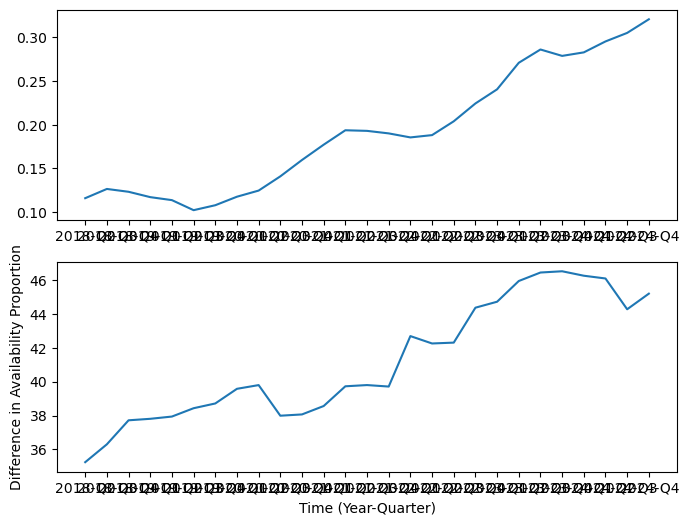

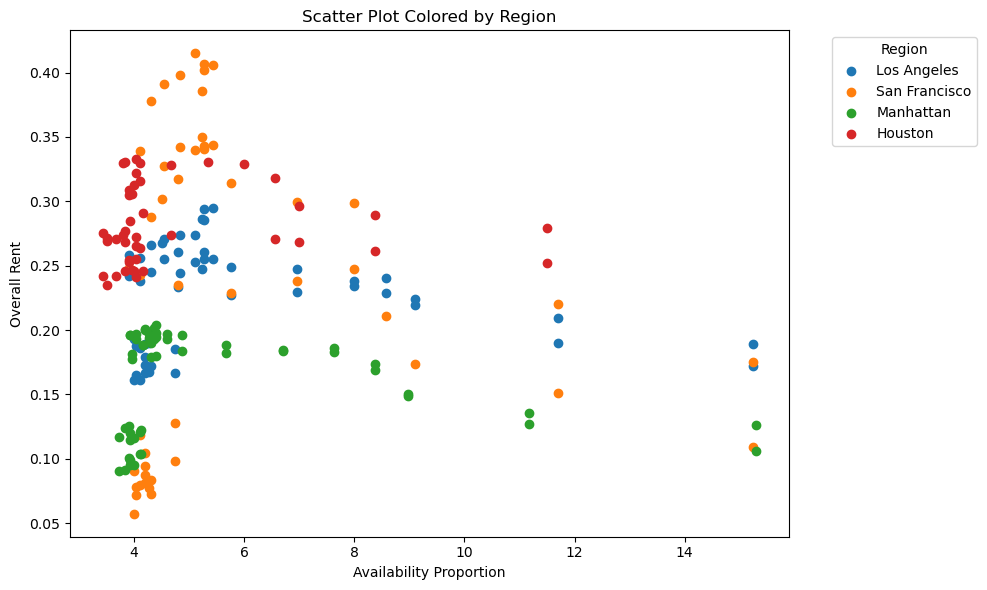

In [18]:

# Set the 'time_index' as the index for easier plotting
#differences_df.set_index('time_index', inplace=True)

ready2graph = differences_df[(differences_df['market'] == 'Seattle') & (differences_df['internal_class'] == 'A')]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6)) # 2 rows, 1 column

axes[0].plot(ready2graph.time_index, ready2graph.availability_proportion, label='Availability Proporiton')
axes[1].plot(ready2graph.time_index, ready2graph.overall_rent, label='rent')

plt.xlabel('Time (Year-Quarter)')
plt.ylabel('Difference in Availability Proportion')
plt.show()

ready2graph = merged[merged['market'].isin(['Manhattan', 'Los Angeles', 'San Francisco', 'Houston'])]

regions = ready2graph['market']  # Replace 'State' with your region column if different
unique_regions = regions.unique()
colors = {region: plt.cm.tab10(i) for i, region in enumerate(unique_regions)}  # Assign colors to regions

plt.figure(figsize=(10, 6))
for region in unique_regions:
    subset = ready2graph[ready2graph['market'] == region]
    plt.scatter(
        subset['unemployment_rate'], 
        subset['availability_proportion'], 
        label=region, 
        color=colors[region]
    )

plt.xlabel('Availability Proportion')
plt.ylabel('Overall Rent')
plt.title('Scatter Plot Colored by Region')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


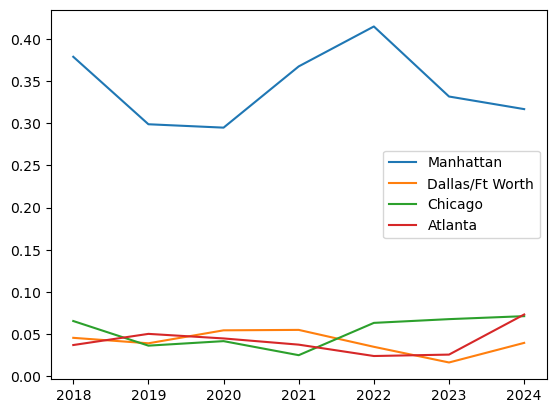

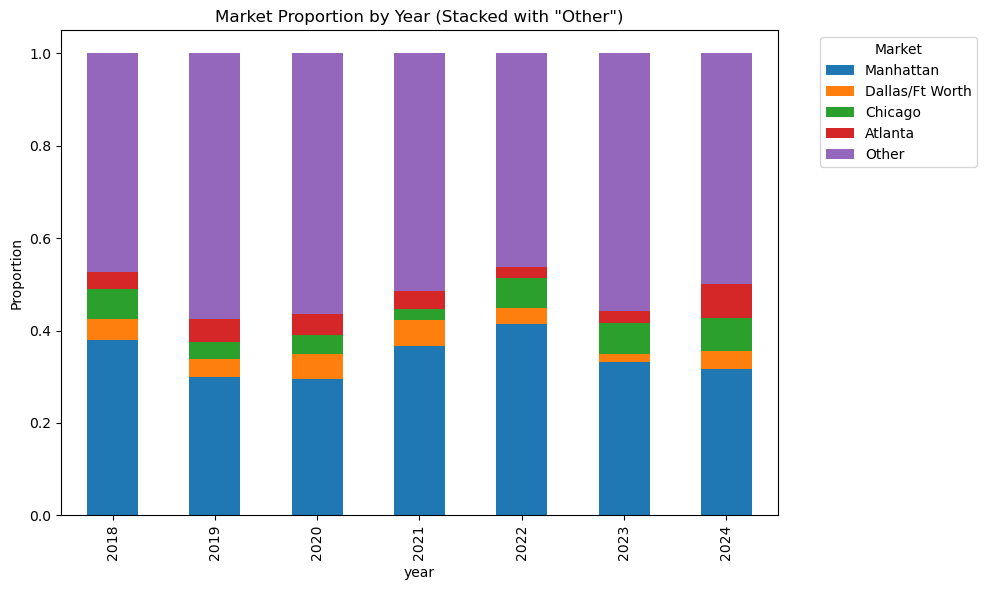

In [10]:

markets_by_industry = leases_df.groupby(['internal_industry'])["market"].value_counts()

markets_by_industry.iloc[1]

tech = leases_df[leases_df.internal_industry == "Technology, Advertising, Media, and Information"]
finance = leases_df[leases_df.internal_industry == "Financial Services and Insurance"]



#tech["market"].value_counts(normalize=True)
proportion = finance.groupby('year')['market'].value_counts(normalize=True)

dictionary = {
    'year':proportion.index.get_level_values(0),
    'market':proportion.index.get_level_values(1),
    'proportion':proportion.values
}

df = pd.DataFrame(dictionary)

for market in ['Manhattan', 'Dallas/Ft Worth', 'Chicago', 'Atlanta']:
    temp = df[df.market == market]
    plt.plot(temp.year, temp.proportion, label=market)
plt.legend()
plt.show()

# Define your focus markets
markets = ['Manhattan', 'Dallas/Ft Worth', 'Chicago', 'Atlanta']

# Replace non-focus markets with 'Other'
df['market_grouped'] = df['market'].where(df['market'].isin(markets), 'Other')

# Group again to recalculate proportions with 'Other'
grouped = df.groupby(['year', 'market_grouped'])['proportion'].sum().reset_index()

# Pivot for stacked bar chart
pivot_df = grouped.pivot(index='year', columns='market_grouped', values='proportion')

# Ensure consistent column order
column_order = markets + ['Other']
pivot_df = pivot_df[column_order]  # This will error if 'Other' isn't present—optional safeguard

# Plot
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.ylabel('Proportion')
plt.title('Market Proportion by Year (Stacked with "Other")')
plt.legend(title='Market', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Linear Models


In [13]:

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np
from scipy import stats

markets = merged['market'].unique()
market_results = {}

for mkt in markets:
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    df_mkt = merged[merged['market'] == mkt]
    X = df_mkt[['overall_rent', 'unemployment_rate']]
    y = df_mkt['availability_proportion']
    
    # Skip if too few samples
    if len(df_mkt) < 30:
        continue
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_reshaped = y_train.values.reshape(-1,1)
    y_train_scaled = scaler_y.fit_transform(y_train_reshaped).flatten()
    

    y_test_reshaped = y_train.values.reshape(-1,1)
    y_test_scaled = scaler_y.transform(y_test_reshaped)



    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)
    
    y_train_pred_scaled = model.predict(X_train_scaled)

    y__train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1,1)).flatten()

    residuals_train = y_train - y__train_pred
    n, k = X_train.shape

    sigma_squared = np.sum(residuals_train ** 2) / (n - k)

    X_train_scaled_with_intercept = np.hstack((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled))
    cov_matrix = sigma_squared * np.linalg.inv(X_train_scaled_with_intercept.T @ X_train_scaled_with_intercept)
    standard_errors = np.sqrt(np.diag(cov_matrix)[1:])

    t_stats = model.coef_ / standard_errors
    p_values = [2 * (1 - stats.t.cdf(np.abs(t), df=n-k)) for t in t_stats]

     # Print results for each coefficient
    print(f"\nMarket: {mkt}")
    print(f"Intercept: {model.intercept_:.4f}")
    for i, (coef, p) in enumerate(zip(model.coef_, p_values)):
        coef_name = X.columns[i]  # Get the name of the coefficient
        print(f"  Coefficient ({coef_name}): {coef:.4f}, p-value: {p}")
    
    market_results[mkt] = {
        'coef': model.coef_,
        'intercept': model.intercept_ 
    }

    



Market: Phoenix
Intercept: -0.0000
  Coefficient (overall_rent): 0.5711, p-value: 0.0
  Coefficient (unemployment_rate): -0.1588, p-value: 0.0

Market: Los Angeles
Intercept: 0.0000
  Coefficient (overall_rent): 0.8537, p-value: 0.0
  Coefficient (unemployment_rate): -0.2737, p-value: 0.0

Market: San Diego
Intercept: -0.0000
  Coefficient (overall_rent): 0.3445, p-value: 0.0
  Coefficient (unemployment_rate): -0.1228, p-value: 0.0

Market: San Francisco
Intercept: -0.0000
  Coefficient (overall_rent): -0.6720, p-value: 0.0
  Coefficient (unemployment_rate): 0.0706, p-value: 2.3163018820104853e-05

Market: South Florida
Intercept: -0.0000
  Coefficient (overall_rent): 0.3329, p-value: 0.0
  Coefficient (unemployment_rate): 0.0185, p-value: 0.00021297439650602712

Market: Tampa
Intercept: -0.0000
  Coefficient (overall_rent): 0.6111, p-value: 0.0
  Coefficient (unemployment_rate): -0.0699, p-value: 2.220446049250313e-16

Market: Atlanta
Intercept: -0.0000
  Coefficient (overall_rent): 

In [17]:
sorted_market = dict(sorted(market_results.items(), key= lambda item: item[1]['coef'][0]))

for market, results in sorted_market.items():
    print(f"Market: {market}, First Coefficient: {results['coef'][0]:.4f}")

Market: San Francisco, First Coefficient: -0.6720
Market: Manhattan, First Coefficient: -0.4832
Market: Northern New Jersey, First Coefficient: -0.0455
Market: Houston, First Coefficient: 0.1580
Market: Baltimore, First Coefficient: 0.2002
Market: Northern Virginia, First Coefficient: 0.2423
Market: South Florida, First Coefficient: 0.3329
Market: San Diego, First Coefficient: 0.3445
Market: Chicago Suburbs, First Coefficient: 0.5113
Market: Phoenix, First Coefficient: 0.5711
Market: Tampa, First Coefficient: 0.6111
Market: Detroit, First Coefficient: 0.6295
Market: Atlanta, First Coefficient: 0.6507
Market: Charlotte, First Coefficient: 0.7124
Market: Boston, First Coefficient: 0.7385
Market: Philadelphia, First Coefficient: 0.8096
Market: Austin, First Coefficient: 0.8162
Market: Los Angeles, First Coefficient: 0.8537
Market: Seattle, First Coefficient: 0.8812


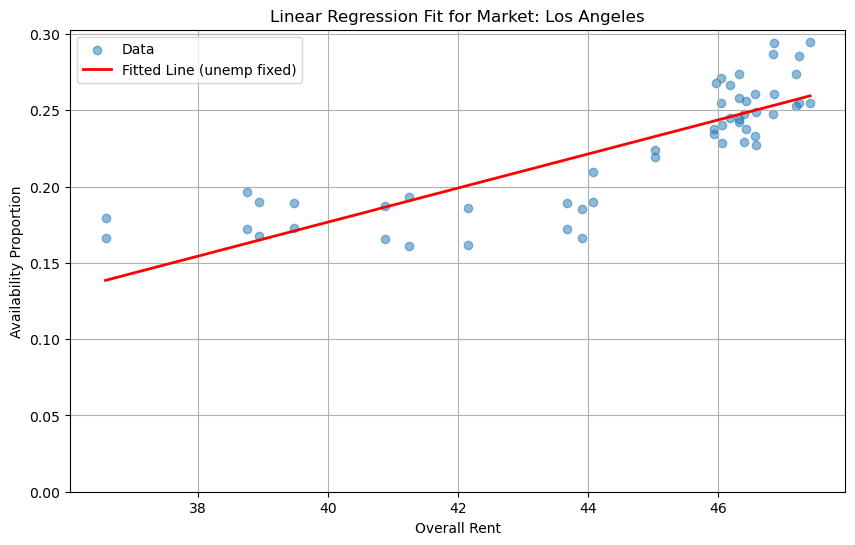

In [ ]:
import matplotlib.pyplot as plt

# Choose a market to visualize
mkt = ''  # replace with an actual market from merged['market'].unique()

df_mkt = merged[merged['market'] == mkt]
X = df_mkt[['overall_rent', 'unemployment_rate']]
y = df_mkt['availability_proportion']

# Scale inputs
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1)).flatten()

# Fit the model
model = LinearRegression()
model.fit(X_scaled, y_scaled)

# Predict over a range of overall_rent values (holding unemployment constant at the mean)
rent_vals = np.linspace(X['overall_rent'].min(), X['overall_rent'].max(), 100)
unemp_fixed = X['unemployment_rate'].mean()
X_plot = pd.DataFrame({
    'overall_rent': rent_vals,
    'unemployment_rate': unemp_fixed
})

X_plot_scaled = scaler_X.transform(X_plot)
y_plot_scaled = model.predict(X_plot_scaled)
y_plot = scaler_y.inverse_transform(y_plot_scaled.reshape(-1,1)).flatten()

# Plotting
plt.figure(figsize=(10,6))
plt.scatter(X['overall_rent'], y, alpha=0.5, label='Data')
plt.plot(rent_vals, y_plot, color='red', linewidth=2, label='Fitted Line (unemp fixed)')
plt.xlabel('Overall Rent')
plt.ylabel('Availability Proportion')
plt.title(f'Linear Regression Fit for Market: {mkt}')
plt.legend()
plt.grid(True)

plt.ylim(bottom=0)
plt.show()


In [78]:
tech

,year,quarter,monthsigned,market,building_name,building_id,address,region,city,state,...,overall_rent,direct_available_space,direct_availability_proportion,direct_internal_class_rent,direct_overall_rent,sublet_available_space,sublet_availability_proportion,sublet_internal_class_rent,sublet_overall_rent,leasing
9,2018,Q1,1.0,Atlanta,271 17th,Atlanta_Midtown_Atlanta_271 17th_271 17th St NW,271 17th St NW,South,Atlanta,GA,...,24.345689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1205126.0
14,2018,Q1,1.0,Atlanta,Bank of America Plaza,Atlanta_Downtown_Atlanta_Bank of America Plaza...,600 Peachtree St NE,South,Atlanta,GA,...,24.345689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1205126.0
82,2018,Q1,1.0,Atlanta,NaN,Atlanta_Midtown_Atlanta_NA_10 10th St,10 10th St,South,Atlanta,GA,...,24.345689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1205126.0
309,2018,Q1,1.0,Boston,University Office Bldg,Boston_Route 495/Mass Pike West_Natick_Univers...,190 N Main St,Northeast,Natick,MA,...,32.409956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,934610.0
387,2018,Q1,1.0,Charlotte,The Hub at Waverly,Charlotte_East Charlotte_Charlotte_The Hub at ...,6210 Ardrey Kell Rd,South,Charlotte,NC,...,26.037735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1130188.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194660,2024,Q4,12.0,South Bay/San Jose,Bldg 2,South Bay/San Jose_North San Jose_San Jose_Bld...,2345 N 1st St,West,San Jose,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194662,2024,Q4,12.0,South Bay/San Jose,Prospect Place,South Bay/San Jose_Santa Clara_Santa Clara_Pro...,2953 Bunker Hill Ln,West,Santa Clara,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194667,2024,Q4,12.0,South Bay/San Jose,NaN,South Bay/San Jose_Menlo Park (San Mateo South...,275 Middlefield Rd,West,Menlo Park,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194668,2024,Q4,12.0,South Bay/San Jose,NaN,South Bay/San Jose_Mountain View/Los Altos_Mou...,800 California St,West,Mountain View,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
